### End to End a/b test project

##### import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### reading the dataset

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


##### Check structure

In [3]:
df.shape

(294478, 5)

In [4]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

##### Handling Duplicates

In [7]:
df['user_id'].duplicated().sum()

np.int64(3894)

In [8]:
df = df.drop_duplicates(subset='user_id')  #removes duplicates

In [9]:
df.shape

(290584, 5)

##### Check group–page mismatch

In [10]:
mismatch = df[((df['group']=='control') & (df['landing_page']=='new_page')) | ((df['group']=='treatment') & (df['landing_page']=='old_page'))]
mismatch.shape

(2044, 5)

In [11]:
df=df.drop(mismatch.index)

In [12]:
mismatch_check = df[((df['group']=='control') & (df['landing_page']=='new_page')) | ((df['group']=='treatment') & (df['landing_page']=='old_page'))]
mismatch_check.shape

(0, 5)

##### Extra Validation

In [13]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,144226
treatment,144314,0


#### Basic EDA

In [14]:
df['group'].value_counts()

group
treatment    144314
control      144226
Name: count, dtype: int64

In [15]:
df['converted'].mean()

np.float64(0.11950856033825466)

In [16]:
df.groupby('group')['converted'].agg(['count','mean'])

,count,mean
group,,
control,144226,0.120290
treatment,144314,0.118727


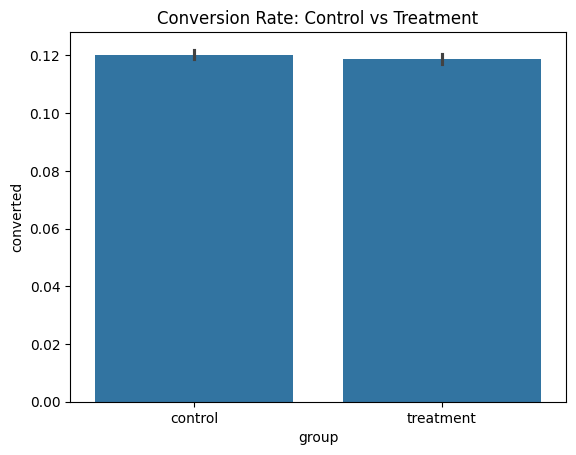

In [17]:
sns.barplot(data=df, x='group', y='converted')
plt.title("Conversion Rate: Control vs Treatment")
plt.show()

#### calculate lift

In [18]:
control_rate = 0.120290
treatment_rate = 0.118727

lift = (treatment_rate - control_rate) / control_rate * 100
lift

-1.2993598802892967

#### Hypothesis Testing

##### z-proportion test

In [19]:
from scipy import stats
import numpy as np

control = df[df['group'] == 'control']['converted']
treatment = df[df['group'] == 'treatment']['converted']

n_control = len(control)
n_treatment = len(treatment)

print("Control:", n_control, "Treatment:", n_treatment)  # sanity check

p_control = control.mean()
p_treatment = treatment.mean()

# pooled probability
p_pool = (control.sum() + treatment.sum()) / (n_control + n_treatment)

# standard error
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_control + 1/n_treatment))

# z-score (treatment - control)
z_score = (p_treatment - p_control) / se

# two-tailed p-value
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

print("Z-score:", z_score)
print("P-value:", p_value)

Control: 144226 Treatment: 144314
Z-score: -1.2942367891190543
P-value: 0.19558364287881425


#### confidence interval

In [20]:
diff = p_treatment - p_control

ci_low = diff - 1.96 * se
ci_high = diff + 1.96 * se

print("95% Confidence Interval:", ci_low, ci_high)

95% Confidence Interval: -0.003930413374464424 0.000804097795532947


##### Conclusion : The new landing page resulted in a 1.3% decrease in conversion compared to the existing page. However, the difference was not statistically significant (p = 0.196). The 95% confidence interval (-0.39%, 0.08%) includes zero, indicating that the observed difference may be due to random variation. Based on this analysis, there is insufficient evidence to recommend deploying the new landing page. It is advised to retain the current design or continue testing with additional data.

In [21]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


##### exporting cleaned sample

In [22]:
df.to_csv("ab_clean.csv", index=False)